Brenno Ludergnani Matricola N. 2142931

Cognition and Computation Project - 12/01/2026

The project regards the construction of Deep Belief Network made of three Restricted Boltzmann Machine layers of the same size.
The model is then trained and evaluated on EMNIST dataset, composed by images of letters from the latin alphabet. The model is evaluated in its capability of classifying correctly the images.
In this notebook there are:
- Model definition.
- Training phase.
- Representation of the receptive fields of neurons.
- Hierarchical clustering representation.
- Linear Read-Out and model evaluation.
- Analysis of the robustness to noise.
- Capability of Few-Shots Learning.
- Confusion Matrix representation.

This project utilizes core DBN and RBM logic adapted from the work of **flavio2018**.
**Original Repository:** [Deep-Belief-Network-pytorch](https://github.com/flavio2018/Deep-Belief-Network-pytorch)
**License:** Refer to the original repository for licensing details.

In [1]:
import torch
import torchvision

print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


In the next cells I used the actual code from the git repository suggested during labs. The purpose of explicitely the code instead of the package was having more control on the functions and their parameters. The first cell regards defining the RBM structure and all the related functions.

In [2]:
# The following class structure is based on the implementation by flavio2018
# Source: https://github.com/flavio2018/Deep-Belief-Network-pytorch

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import sys

BATCH_SIZE = 64

class RBM(nn.Module):

    def __init__(self,
                 visible_units,
                 hidden_units,
                 k,
                 learning_rate,
                 learning_rate_decay,
                 weight_decay,
                 initial_momentum,
                 final_momentum,
                 xavier_init,
                 increase_to_cd_k,
                 use_gpu):

        super(RBM, self).__init__()
        self.desc = "RBM"

        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.weight_decay = weight_decay
        self.momentum = initial_momentum
        self.final_momentum = final_momentum
        self.xavier_init = xavier_init
        self.increase_to_cd_k = increase_to_cd_k
        self.use_gpu = use_gpu
        self.batch_size = 16

        if not self.xavier_init:
            self.W = torch.randn(self.visible_units,
                                 self.hidden_units) * 0.1  # weights
        else:
            self.xavier_value = torch.sqrt(
                torch.FloatTensor(
                    [1.0 / (self.visible_units + self.hidden_units)]))
            self.W = -self.xavier_value + \
                torch.rand(self.visible_units, self.hidden_units) * (2 * self.xavier_value)
        self.h_bias = torch.zeros(self.hidden_units)  # hidden layer bias
        self.v_bias = torch.zeros(self.visible_units)  # visible layer bias

        self.v_bias_update = torch.zeros(self.visible_units)
        self.h_bias_update = torch.zeros(self.hidden_units)
        self.grad_update = torch.zeros(self.visible_units, self.hidden_units)

        if self.use_gpu:
            self.W = self.W.cuda()
            self.h_bias = self.h_bias.cuda()
            self.v_bias = self.v_bias.cuda()
            self.v_bias_update = self.v_bias_update.cuda()
            self.h_bias_update = self.h_bias_update.cuda()
            self.grad_update = self.grad_update.cuda()

    def to_hidden(self, X):
        X_prob = torch.matmul(X, self.W)
        X_prob = torch.add(X_prob, self.h_bias)  # W.x + c
        X_prob = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)
        return X_prob, sample_X_prob

    def to_visible(self, X):
        X_prob = torch.matmul(X, self.W.transpose(0, 1))
        X_prob = torch.add(X_prob, self.v_bias)
        X_prob = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)
        return X_prob, sample_X_prob

    def sampling(self, prob):
        s = torch.distributions.Bernoulli(prob).sample()
        return s

    def reconstruction_error(self, data):
        return self.contrastive_divergence(data, False)

    def reconstruct(self, X, n_gibbs):
        v = X
        for i in range(n_gibbs):
            prob_h_, h = self.to_hidden(v)
            prob_v_, v = self.to_visible(prob_h_)
        return prob_v_, v

    def contrastive_divergence(self,
                               input_data,
                               training=True,
                               n_gibbs_sampling_steps=1,
                               lr=0.001):

        positive_hidden_probabilities, positive_hidden_act = self.to_hidden(
            input_data)

        positive_associations = torch.matmul(input_data.t(),
                                             positive_hidden_probabilities)

        hidden_activations = positive_hidden_act
        for i in range(n_gibbs_sampling_steps):
            visible_probabilities, _ = self.to_visible(hidden_activations)
            hidden_probabilities, hidden_activations = self.to_hidden(
                visible_probabilities)

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        negative_associations = torch.matmul(
            negative_visible_probabilities.t(), negative_hidden_probabilities)

        if training:
            batch_size = self.batch_size

            g = (positive_associations - negative_associations)
            self.grad_update = self.momentum * self.grad_update + lr * (g / batch_size - self.weight_decay * self.W)
            self.v_bias_update = self.momentum * self.v_bias_update + lr * torch.sum(
                input_data - negative_visible_probabilities,
                dim=0) / batch_size
            self.h_bias_update = self.momentum * self.h_bias_update + lr * torch.sum(
                positive_hidden_probabilities - negative_hidden_probabilities,
                dim=0) / batch_size

            self.W += self.grad_update
            self.v_bias += self.v_bias_update
            self.h_bias += self.h_bias_update

        error = torch.mean(
            torch.sum((input_data - negative_visible_probabilities)**2, dim=0))

        return error, torch.sum(torch.abs(self.grad_update))

    def forward(self, input_data):
        return self.to_hidden(input_data)

    def step(self, input_data, epoch, num_epochs):
        if self.increase_to_cd_k:
            n_gibbs_sampling_steps = int(
                math.ceil((epoch / num_epochs) * self.k))
        else:
            n_gibbs_sampling_steps = self.k

        if self.learning_rate_decay:
            lr = self.learning_rate / epoch
        else:
            lr = self.learning_rate

        if epoch > 5:
            self.momentum = self.final_momentum

        return self.contrastive_divergence(input_data, True,
                                           n_gibbs_sampling_steps, lr)

    def train(self, train_dataloader, num_epochs, batch_size):

        self.batch_size = batch_size
        if (isinstance(train_dataloader, torch.utils.data.DataLoader)):
            train_loader = train_dataloader
        else:
            train_loader = torch.utils.data.DataLoader(train_dataloader,
                                                       batch_size=batch_size)

        print("|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |")
        for epoch in range(1, num_epochs + 1):
            epoch_err = 0.0
            n_batches = int(len(train_loader))

            cost_ = torch.FloatTensor(n_batches, 1)
            grad_ = torch.FloatTensor(n_batches, 1)

            for i, (batch, _) in enumerate(train_loader):

                batch = batch.view(len(batch), self.visible_units)
                if self.use_gpu:
                    batch = batch.cuda()
                cost_[i - 1], grad_[i - 1] = self.step(batch, epoch,
                                                       num_epochs)

            if epoch % 10 == 0:
                print("|{:02d}    |{:.4f}     "
                      "|{:.4f}       |{:.4f}   "
                      "|{:.4f}     |".format(epoch, torch.mean(cost_), torch.std(cost_), torch.mean(grad_), torch.std(grad_)))
        return

The next cell regards the definition of Deep Belief Network, based on the previous description of RBM.

In [3]:
# The following class structure is based on the implementation by flavio2018
# Source: https://github.com/flavio2018/Deep-Belief-Network-pytorch

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class DBN(nn.Module):
    def __init__(self,
                 visible_units,
                 hidden_units,
                 k,
                 learning_rate,
                 learning_rate_decay,
                 weight_decay,
                 initial_momentum,
                 final_momentum,
                 xavier_init,
                 increase_to_cd_k,
                 use_gpu):
        super(DBN, self).__init__()

        self.device = torch.device("cuda") if use_gpu else torch.device("cpu")
        self.n_layers = len(hidden_units)
        self.rbm_layers = []
        self.rbm_nodes = []

        for i in range(self.n_layers):
            input_size = 0
            if i == 0:
                input_size = visible_units
            else:
                input_size = hidden_units[i - 1]
            rbm = RBM(visible_units=input_size,
                      hidden_units=hidden_units[i],
                      k=k,
                      learning_rate=learning_rate,
                      learning_rate_decay=learning_rate_decay,
                      weight_decay=weight_decay,
                      initial_momentum=initial_momentum,
                      final_momentum=final_momentum,
                      xavier_init=xavier_init,
                      increase_to_cd_k=increase_to_cd_k,
                      use_gpu=use_gpu)

            self.rbm_layers.append(rbm)

        self.W_rec = [
            nn.Parameter(self.rbm_layers[i].W.data.clone())
            for i in range(self.n_layers - 1)
        ]
        self.W_gen = [
            nn.Parameter(self.rbm_layers[i].W.data)
            for i in range(self.n_layers - 1)
        ]
        self.bias_rec = [
            nn.Parameter(self.rbm_layers[i].h_bias.data.clone())
            for i in range(self.n_layers - 1)
        ]
        self.bias_gen = [
            nn.Parameter(self.rbm_layers[i].v_bias.data)
            for i in range(self.n_layers - 1)
        ]
        self.W_mem = nn.Parameter(self.rbm_layers[-1].W.data)
        self.v_bias_mem = nn.Parameter(self.rbm_layers[-1].v_bias.data)
        self.h_bias_mem = nn.Parameter(self.rbm_layers[-1].h_bias.data)

        for i in range(self.n_layers - 1):
            self.register_parameter('W_rec%i' % i, self.W_rec[i])
            self.register_parameter('W_gen%i' % i, self.W_gen[i])
            self.register_parameter('bias_rec%i' % i, self.bias_rec[i])
            self.register_parameter('bias_gen%i' % i, self.bias_gen[i])

    def forward(self, input_data):
        v = input_data
        for i in range(len(self.rbm_layers)):
            v = v.view((v.shape[0], -1))  # flatten
            p_v, v = self.rbm_layers[i].to_hidden(v)
        return p_v, v

    def reconstruct(self, input_data):
        p_h = input_data
        for i in range(len(self.rbm_layers)):
            p_h = p_h.view((p_h.shape[0], -1)).type(torch.FloatTensor).to(self.device)  # flatten
            p_h, h = self.rbm_layers[i].to_hidden(p_h)

        p_v = p_h
        for i in range(len(self.rbm_layers) - 1, -1, -1):
            p_v = p_v.view((p_v.shape[0], -1)).type(torch.FloatTensor).to(self.device)
            p_v, v = self.rbm_layers[i].to_visible(p_v)
        return p_v, v

    def train_static(self,
                     train_data,
                     train_labels,
                     num_epochs,
                     batch_size):

        tmp = train_data

        for i in range(len(self.rbm_layers)):
            print("-" * 20)
            print("Training RBM layer {}".format(i + 1))

            tensor_x = tmp.type(torch.FloatTensor)
            
            tensor_y = train_labels.type(torch.FloatTensor)
            _dataset = torch.utils.data.TensorDataset(
                tensor_x, tensor_y) 
            _dataloader = torch.utils.data.DataLoader(
                _dataset, batch_size=batch_size,
                drop_last=True)  

            self.rbm_layers[i].train(_dataloader, num_epochs, batch_size)
            print(train_data.shape)
            v = tmp.view((tmp.shape[0], -1)).type(torch.FloatTensor)  
            if self.rbm_layers[i].use_gpu:
                v = v.cuda()
            p_v, v = self.rbm_layers[i].forward(v)
            tmp = p_v
            print(v.shape)
        return

    def train_ith(self, train_data, train_labels, num_epochs, batch_size,
                  ith_layer):
        if (ith_layer - 1 > len(self.rbm_layers) or ith_layer <= 0):
            print("Layer index out of range")
            return
        ith_layer = ith_layer - 1
        v = train_data.view((train_data.shape[0], -1)).type(torch.FloatTensor)

        for ith in range(ith_layer):
            p_v, v = self.rbm_layers[ith].forward(v)

        tmp = v
        tensor_x = tmp.type(torch.FloatTensor)  
        tensor_y = train_labels.type(torch.FloatTensor)
        _dataset = torch.utils.data.TensorDataset(
            tensor_x, tensor_y)  
        _dataloader = torch.utils.data.DataLoader(_dataset,
                                                  batch_size=batch_size,
                                                  drop_last=True)
        self.rbm_layers[ith_layer].train(_dataloader, num_epochs, batch_size)
        return

We define our DBN model. Input images are composed by 28*28=784 pixels, we define an RBM with visible layer's size at least as big as the number of pixels in the images. This one-to-one feature mapping forces the RBM-layer to learn the complex relationships between the single pixels, without compressing the original image.
The choice of 784, which is a relatively small number, is also justified by the need to create a manageable model, avoiding very large configurations, which have more learning-power but are also more prone to overfit the task.
Also the second and third have the same size in order to not losing information, and create a stable model.
The current parameter are chosen after the fine tuning pahse, primarily realized by observing the receptive fields of the neurons.

In [4]:
dbn_emnist = DBN(visible_units=784,            
                 hidden_units=[784, 784, 784], 
                 k=2,                           
                 learning_rate=0.02,           
                 learning_rate_decay=False,
                 weight_decay=0.00001,             
                 initial_momentum=0.5,
                 final_momentum=0.9,
                 xavier_init=False,
                 increase_to_cd_k=False,
                 use_gpu=torch.cuda.is_available())

We import the EMNIST dataset, composed by images depicting letters from the latin alphabet. Particularly we have 26 different classes.
Due to the peculiar characteristics of the original dataset, we apply transformation and augmentation techniques by creating specular images, rotating them and trasnforming them into tensors. We applied the same transformations both to training and test set.

In [5]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#------Data transformations: from image to tensor, rotation -90°, flip of the image.
data_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
])


#----- Datasets Download----
train_dataset = tv.datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=data_transform
)
test_dataset = tv.datasets.EMNIST(
    root ='./data', split ='letters', train=False, download=True, transform=data_transform
)


#---- Function for the conversion a pytorch dataset into tensors------
def get_data_tensors(dataset, device):
    data_list = []
    labels_list = []
    
    for i in range(len(dataset)):
        item = dataset[i]
        data_list.append(item[0])
        labels_list.append(torch.tensor(item[1]))

    images = torch.stack(data_list).to(device)
    labels = torch.stack(labels_list).to(device)

    data_flat = images.view(-1, 28 * 28)
    
    labels_0indexed = labels - 1 
    return data_flat, labels_0indexed

print(f"Using device: {device}")
train_data, train_labels = get_data_tensors(train_dataset, device)
test_data, test_labels = get_data_tensors(test_dataset, device)

100%|██████████| 562M/562M [00:02<00:00, 249MB/s]


Using device: cuda


We train our DBN model on the transformed EMNIST training set. The training duration is 50 epochs balancing improvements and training time.

In [6]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(
    train_data,
    train_labels,
    num_epochs,
    batch_size
)

print("model trained")

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.9275     |0.0593       |117.9323   |3.0921     |
|20    |1.7855     |0.0533       |108.5091   |2.5434     |
|30    |1.7334     |0.0503       |104.5146   |2.3863     |
|40    |1.7015     |0.0485       |101.3514   |2.1458     |
|50    |1.6843     |0.0476       |99.6259   |2.3287     |
torch.Size([124800, 784])
torch.Size([124800, 784])
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6315     |0.0432       |111.6841   |2.5605     |
|20    |1.4782     |0.0368       |102.4001   |2.0142     |
|30    |1.4506     |0.0368       |100.6555   |2.1731     |
|40    |1.4353     |0.0357       |99.6521   |1.9859     |
|50    |1.4269     |0.0348       |99.4574   |2.0768     |
torch.Size([124800, 784])
torch.Size([124800, 784])
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1

This are the functions for:
- get_weights: extracting the RBM-layer weights.
- apply_threshold: checks every weight, if it is less than the threshold it is set to zero.
- apply_min_max_scaler: weights normalization into [0,1]
- plot_layer_receptive_fields: plot the receptive fields of the different layers.

In [7]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

Using the previously defined function, by reshaping into a 28*28 picture the weights of the RBM-layers, we are able to visualize the receptive field of the hidden units of the DBN.
The majority of receptive fields exhibit coherent topological structures, such as edge detectors and stroke segments, consistent with the handwritten characters in EMNIST.
The presence of some noisy receptive fields indicates a subset of neurons that did not converge to a specific spatial feature.

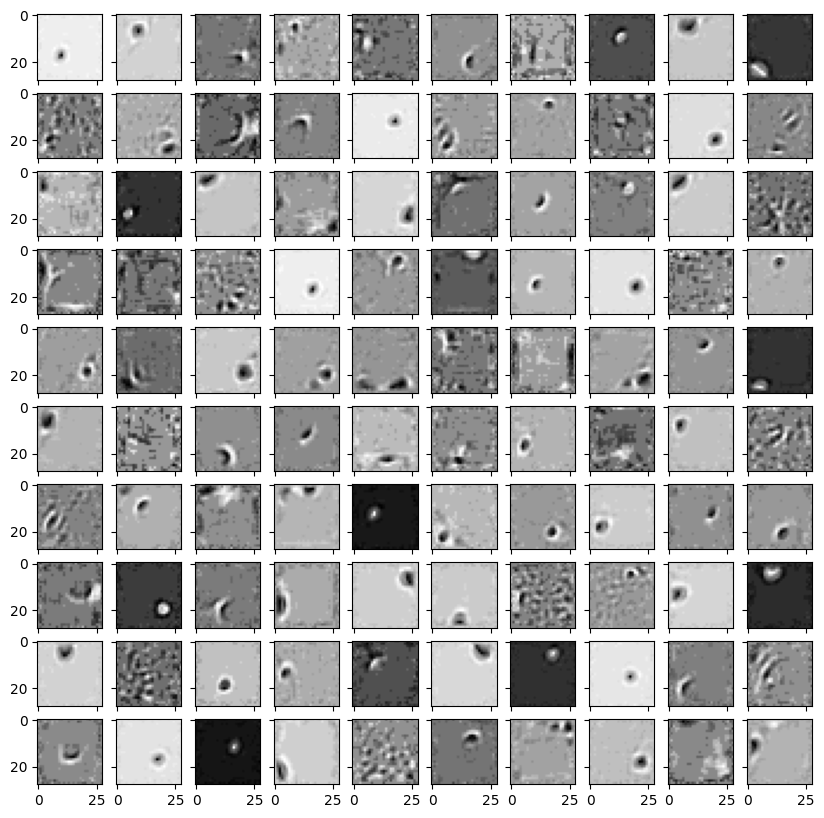

In [8]:
import sklearn.preprocessing
import math
import matplotlib.pyplot as plt

w1 = get_weights(dbn_emnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

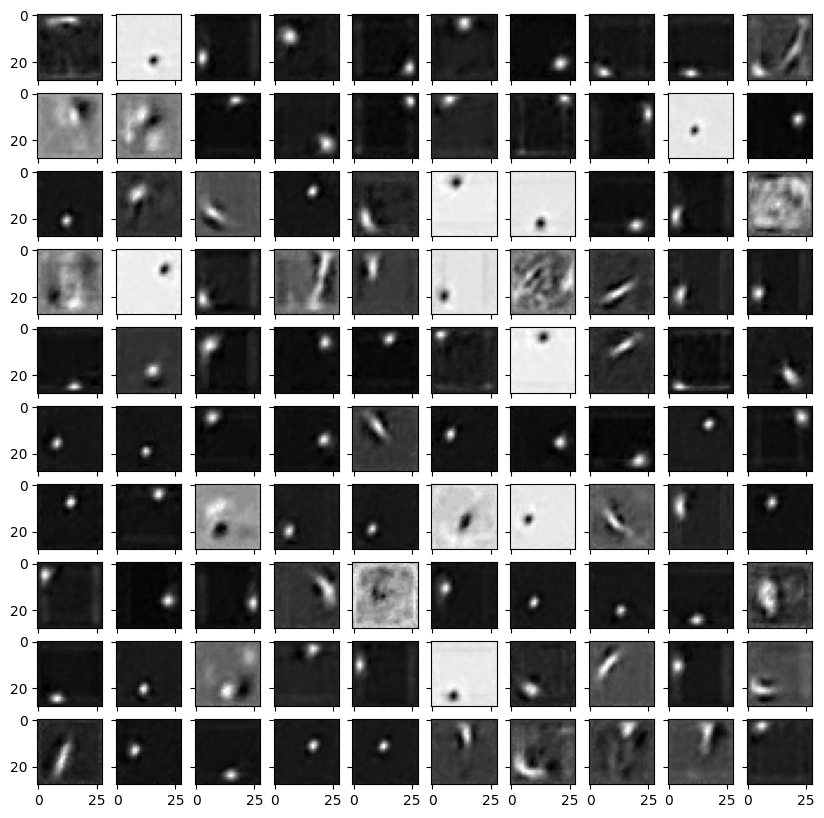

In [9]:
w1 = get_weights(dbn_emnist, layer=0)
w2 = get_weights(dbn_emnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

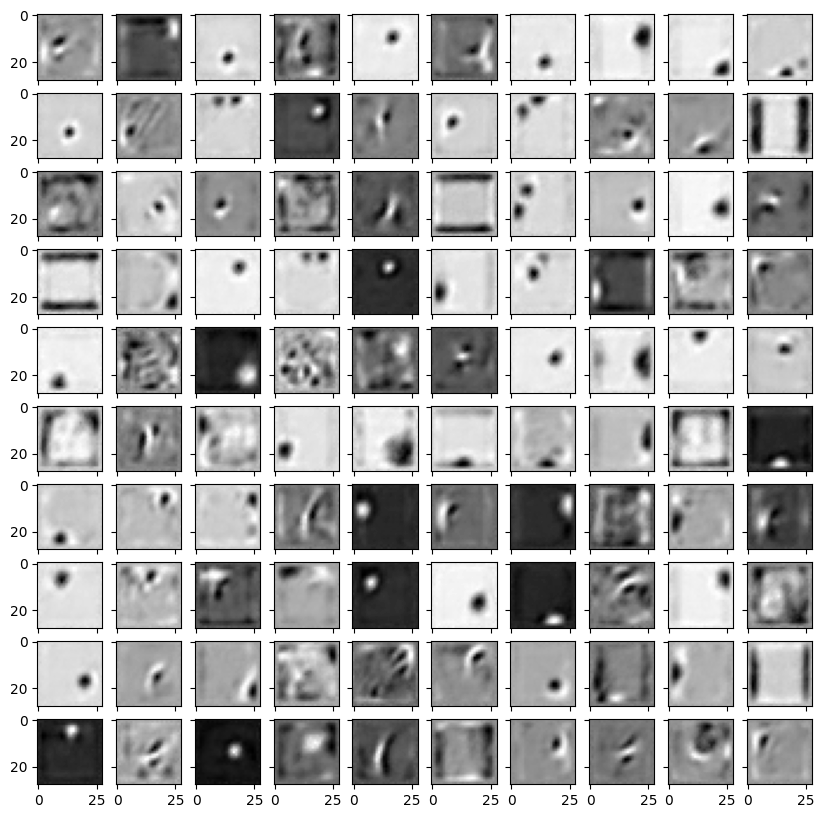

In [10]:
w1 = get_weights(dbn_emnist, layer=0)
w2 = get_weights(dbn_emnist, layer=1)
w3 = get_weights(dbn_emnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

In [11]:
#--- takes raw data and pushes it into the k-th layer to see how data is perceived by that layer.

def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr



In [12]:
hidden_repr_1 = get_kth_layer_repr(train_data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([124800, 784])
torch.Size([124800, 784])
torch.Size([124800, 784])


In [13]:
import numpy as np

def get_mask(label):  # we use this function to filter by class
  labels = train_labels.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(26)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(26)])

In [14]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)
print(mean_hidd_repr_matrix_3.shape)

(26, 784)


In [15]:

def plot_dendrogram(mean_repr_matrix, title=""):
    alphabet_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(
        linkage,
        labels = alphabet_labels
    )
    ax.set_title(title)

Hierarchical clustering shows how the model depicts some letters as "similar" by enclosing them into the same "cluster".
The similarity between letters is due to their particular structure, and it is coherent with human perspective, as we can can observe how our model finds letters 'F' and 'P' very similar to each other. This shows high-level understing of characters structures.

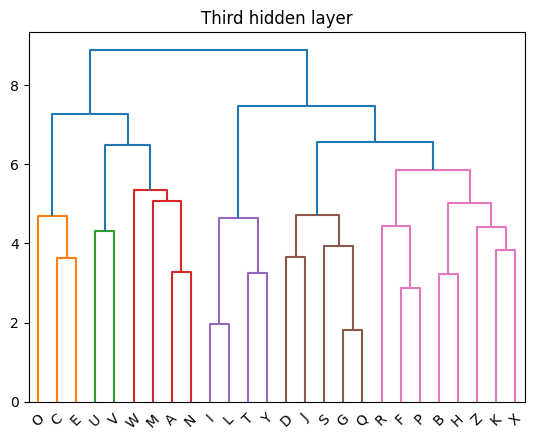

In [16]:
import scipy.cluster as cluster


plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

A linear model is implemented on top of the DBN model, in order to perform a classification task. Particularly the linear model utilizes the DBN unsupervised knowledge as base knowledge. Based on that character recognition is performed with high-accuracy, indicating the prior knowledge delivered by the DBN is precise and suitable for this task.

In [17]:
#Linear model implemented on top of the DBN. Classification layer to evaluate how is the dbn learning.

import torch
import torch.nn as nn
import torch.optim as optim

class LinearModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

num_classes = 30 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layer_size_1 = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size_1, num_classes).to(device)

layer_size_2 = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size_2, num_classes).to(device)

layer_size_3 = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size_3, num_classes).to(device)


def train_linear(model, hidden_reprs, train_labels):

    inputs = hidden_reprs.detach().to(device) 
    targets = train_labels.to(device).long()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    
    epochs = 1000
    model.train() 

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        predictions = model(inputs) 
        targets = targets.reshape(predictions.shape[0])
        
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss.item()))

print("Training Linear 1...")
train_linear(linear1, hidden_repr_1, train_labels)

print("Training Linear 2...")
train_linear(linear2, hidden_repr_2, train_labels)

print("Training Linear 3...")
train_linear(linear3, hidden_repr_3, train_labels)

# 5. TESTING
# (Your testing code remains mostly the same)
hidden_repr_1_test = get_kth_layer_repr(test_data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

def compute_accuracy(predictions_test, targets):
    predictions_test_cpu = predictions_test.cpu()
    predictions_indices = predictions_test_cpu.max(axis=1).indices 
    targets = targets.cpu()
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

print(f"Accuracy 1: {compute_accuracy(predictions_test1, test_labels):.4f}")
print(f"Accuracy 2: {compute_accuracy(predictions_test2, test_labels):.4f}")
print(f"Accuracy 3: {compute_accuracy(predictions_test3, test_labels):.4f}")

Training Linear 1...
epoch :   1/1000, loss = 3.4079
epoch : 101/1000, loss = 0.5622
epoch : 201/1000, loss = 0.4374
epoch : 301/1000, loss = 0.3801
epoch : 401/1000, loss = 0.3458
epoch : 501/1000, loss = 0.3225
epoch : 601/1000, loss = 0.3057
epoch : 701/1000, loss = 0.2921
epoch : 801/1000, loss = 0.2815
epoch : 901/1000, loss = 0.2728
Training Linear 2...
epoch :   1/1000, loss = 3.4336
epoch : 101/1000, loss = 0.5212
epoch : 201/1000, loss = 0.3974
epoch : 301/1000, loss = 0.3419
epoch : 401/1000, loss = 0.3096
epoch : 501/1000, loss = 0.2880
epoch : 601/1000, loss = 0.2722
epoch : 701/1000, loss = 0.2600
epoch : 801/1000, loss = 0.2502
epoch : 901/1000, loss = 0.2421
Training Linear 3...
epoch :   1/1000, loss = 3.4564
epoch : 101/1000, loss = 0.4716
epoch : 201/1000, loss = 0.3675
epoch : 301/1000, loss = 0.3205
epoch : 401/1000, loss = 0.2936
epoch : 501/1000, loss = 0.2740
epoch : 601/1000, loss = 0.2601
epoch : 701/1000, loss = 0.2494
epoch : 801/1000, loss = 0.2414
epoch : 9

In the following cell we run a supervised linear classifier in order to compare performances between supervised and unsupervised approaches, noting that in both cases we obtain very accurate models.

In [18]:
#Supervised baseline neural network to evaluate a model handle the dataset, without a dbn representation.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset 
import torchvision as tv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FeedforwardDBNBaseline(nn.Module):
    def __init__(self, input_size, h1, h2, h3, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.output = nn.Linear(h3, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.output(x)

train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

model = FeedforwardDBNBaseline(784, 784, 784, 784, 26).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Acc: {100.*correct/total:.2f}%")

def test():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    print(f"Final Test Accuracy: {100. * correct / total:.2f}%")

train(epochs=5)
test()

Epoch 1/5 | Loss: 0.5797 | Acc: 81.86%
Epoch 2/5 | Loss: 0.2918 | Acc: 90.21%
Epoch 3/5 | Loss: 0.2296 | Acc: 92.12%
Epoch 4/5 | Loss: 0.1963 | Acc: 93.02%
Epoch 5/5 | Loss: 0.1706 | Acc: 93.78%
Final Test Accuracy: 91.24%


In this case we apply a noise corruption function to modify the EMNIST test instances. 
Thus we utlize the Deep Belief Network previously trained on a clean dataset and then we evaluate the performances of a linear classifier using DBN prior knowledge on the corrupted test set. This test shows the robustness of the model to noise, which is regulated by the intensity parameter we can find in the function AddRandomNoise(). In this case the noise intensity parameter is set as intensity=0.4, which leads to a 10% accuracy.

In [19]:
#Evaluation of a DBN trained on  clean training data and evaluated on a corrupted test set.
# use this to understand if DBN is able to learn deep hidden features.

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset 
import torchvision as tv

class AddRandomNoise(object):
    def __init__(self, intensity):
        self.intensity = intensity
    
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.intensity
        return torch.clamp(tensor + noise, 0, 1)

test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: transforms.functional.rotate(x, -90)),
    transforms.Lambda(lambda x: transforms.functional.hflip(x)),
    AddRandomNoise(0.4) 

])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("preprocessing of data")



noisy_test_dataset = tv.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=test_transform)
noisy_test_loader= torch.utils.data.DataLoader(noisy_test_dataset, batch_size=len(noisy_test_dataset))
images, raw_labels = next(iter(noisy_test_loader))
noisy_test_data = images.view(-1,784).to(device)
noisy_test_labels = (raw_labels -1 ).to(device)

print("Test Dataset Aquired...")

class LinearModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

num_classes = 26
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layer_size_1 = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size_1, num_classes).to(device)

layer_size_2 = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size_2, num_classes).to(device)

layer_size_3 = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size_3, num_classes).to(device)


def train_linear(model, hidden_reprs, train_labels):

    inputs = hidden_reprs.detach().to(device) 
    targets = train_labels.to(device).long()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    
    epochs = 1000
    model.train() 

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(inputs) 
        targets = targets.reshape(predictions.shape[0])
        
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss.item()))


def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

hidden_repr_1 = get_kth_layer_repr(train_data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

print("Training Linear 1...")
train_linear(linear1, hidden_repr_1, train_labels)

print("Training Linear 2...")
train_linear(linear2, hidden_repr_2, train_labels)

print("Training Linear 3...")
train_linear(linear3, hidden_repr_3, train_labels)

hidden_repr_1_test = get_kth_layer_repr(noisy_test_data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

def compute_accuracy(predictions_test, targets):
    predictions_test_cpu = predictions_test.cpu()
    predictions_indices = predictions_test_cpu.max(axis=1).indices 
    targets = targets.cpu()
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

print(f"Accuracy 1: {compute_accuracy(predictions_test1, noisy_test_labels):.4f}")
print(f"Accuracy 2: {compute_accuracy(predictions_test2, noisy_test_labels):.4f}")
print(f"Accuracy 3: {compute_accuracy(predictions_test3, noisy_test_labels):.4f}")


preprocessing of data
Test Dataset Aquired...
torch.Size([124800, 784])
torch.Size([124800, 784])
torch.Size([124800, 784])
Training Linear 1...
epoch :   1/1000, loss = 3.2951
epoch : 101/1000, loss = 0.5664
epoch : 201/1000, loss = 0.4400
epoch : 301/1000, loss = 0.3815
epoch : 401/1000, loss = 0.3467
epoch : 501/1000, loss = 0.3231
epoch : 601/1000, loss = 0.3059
epoch : 701/1000, loss = 0.2924
epoch : 801/1000, loss = 0.2816
epoch : 901/1000, loss = 0.2731
Training Linear 2...
epoch :   1/1000, loss = 3.2770
epoch : 101/1000, loss = 0.5220
epoch : 201/1000, loss = 0.3979
epoch : 301/1000, loss = 0.3424
epoch : 401/1000, loss = 0.3101
epoch : 501/1000, loss = 0.2883
epoch : 601/1000, loss = 0.2725
epoch : 701/1000, loss = 0.2602
epoch : 801/1000, loss = 0.2503
epoch : 901/1000, loss = 0.2421
Training Linear 3...
epoch :   1/1000, loss = 3.2963
epoch : 101/1000, loss = 0.4782
epoch : 201/1000, loss = 0.3721
epoch : 301/1000, loss = 0.3243
epoch : 401/1000, loss = 0.2960
epoch : 501/1

In [20]:
#Simplest possible model to perform our task.

linear_baseline = LinearModel(784, 26).to(device)
print("Training Baseline (Raw Pixels)...")
train_linear(linear_baseline, train_data, train_labels)

eval_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: transforms.functional.rotate(x, -90)),
    transforms.Lambda(lambda x: transforms.functional.hflip(x)),
])

eval_dataset = tv.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=eval_transform)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=len(eval_dataset))

test_images_raw, test_labels_raw = next(iter(eval_loader))
clean_test_data = test_images_raw.view(-1, 784).to(device)
test_labels = (test_labels_raw - 1).to(device) 

Training Baseline (Raw Pixels)...
epoch :   1/1000, loss = 3.2584
epoch : 101/1000, loss = 1.0091
epoch : 201/1000, loss = 0.9737
epoch : 301/1000, loss = 0.9548
epoch : 401/1000, loss = 0.9427
epoch : 501/1000, loss = 0.9342
epoch : 601/1000, loss = 0.9284
epoch : 701/1000, loss = 0.9242
epoch : 801/1000, loss = 0.9206
epoch : 901/1000, loss = 0.9171


In [21]:
#Generate the robustness profile, how much noise my model can handle before it brakes?

def get_accuracy_values_at_noise_level(noise_level):
    noise = torch.randn_like(clean_test_data) * noise_level
    noisy_input = torch.clamp(clean_test_data + noise, 0, 1)

    with torch.no_grad():
        h1 = get_kth_layer_repr(noisy_input, 0, device)
        h2 = get_kth_layer_repr(h1, 1, device)
        h3 = get_kth_layer_repr(h2, 2, device)

        acc1 = compute_accuracy(linear1(h1), test_labels)
        acc2 = compute_accuracy(linear2(h2), test_labels)
        acc3 = compute_accuracy(linear3(h3), test_labels)
        
        acc_base = compute_accuracy(linear_baseline(noisy_input), test_labels)

    return acc1, acc2, acc3, acc_base

def plot_noise_robustness_curves(noise_levels):
    results = {"L1": [], "L2": [], "L3": [], "Base": []}

    for level in noise_levels:
        print(f"Evaluating Noise Level: {level:.2f}")
        a1, a2, a3, ab = get_accuracy_values_at_noise_level(level)
        results["L1"].append(a1)
        results["L2"].append(a2)
        results["L3"].append(a3)
        results["Base"].append(ab)

    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, results["L1"], '-o', label="Layer 1 Hidden")
    plt.plot(noise_levels, results["L2"], '-s', label="Layer 2 Hidden")
    plt.plot(noise_levels, results["L3"], '-^', label="Layer 3 Hidden")
    plt.plot(noise_levels, results["Base"], '--k', label="Raw Pixel Baseline")

    plt.title("DBN Robustness vs. Raw Pixel Baseline")
    plt.xlabel("Noise Intensity (Sigma)")
    plt.ylabel("Classification Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

The following plot shows how injecting increasingly intense noise affect the performances of the layers of the DBN. Also it is shown how noise affect the linear model performances. We can notice how initially DBN layers are actually more robust than the linear model, however when intensity reaches 0.5 the curves are flattened and the accuracy becomes the same as the accuracy of a random guesser.

Evaluating Noise Level: 0.00
Evaluating Noise Level: 0.17
Evaluating Noise Level: 0.33
Evaluating Noise Level: 0.50
Evaluating Noise Level: 0.67
Evaluating Noise Level: 0.83
Evaluating Noise Level: 1.00
Evaluating Noise Level: 1.17
Evaluating Noise Level: 1.33
Evaluating Noise Level: 1.50


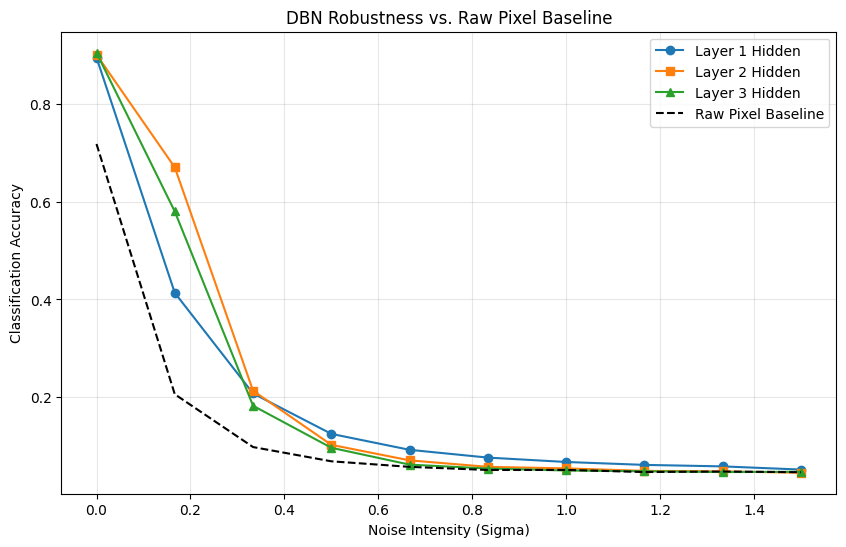

In [22]:
#plot noise robustness.

import numpy as np
noise_levels = np.linspace(0, 1.5, 10)
plot_noise_robustness_curves(noise_levels)

To conclude our analysis, we evaluate the model’s ability to perform Few-Shot Learning. This test determines if the unsupervised features learned by the DBN are robust enough to allow a classifier to learn with extreme data scarcity.

We used the previously trained DBN  structure in a new training process involving only the 0.1% of the original training set, leading to a set composed by 124 input images.
Assuming the alphabet letters are randomly and uniformly distributed, this reduction provides approximately 4–5 labeled examples per class. We could refer to this as a "five-shot" scenario.

Finally a linear model is implemented on top od the DBN in order to translate the knowledge acquired by the DBN during the few-shot learning phase and perform class recognition.

This process led to slightly less than 40% accuracy, which is actually a very good result.

In [23]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#------Data transformations: from image to tensor, rotation -90°, flip of the image.
data_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
])

#---- Function for the conversion a pytorch dataset into tensors------
def get_data_tensors(dataset, device, reduction):
    data_list = []
    labels_list = []
    n_instances=0

    if reduction :
        n_instances = int(len(dataset)*0.001)
        print(f"Training set is made of: {n_instances}")
    else: 
        n_instances = len(dataset)
    
    for i in range(n_instances):
        item = dataset[i]
        data_list.append(item[0])
        labels_list.append(torch.tensor(item[1]))

    images = torch.stack(data_list).to(device)
    labels = torch.stack(labels_list).to(device)

    data_flat = images.view(-1, 28 * 28)
    
    labels_0indexed = labels - 1 
    return data_flat, labels_0indexed

print(f"Using device: {device}")

nn_train_data, nn_train_labels = get_data_tensors(train_dataset, device, True)

#Linear model implemented on top of the DBN. Classification layer to evaluate how is the dbn learning.


class LinearModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

num_classes = 26 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layer_size_1 = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size_1, num_classes).to(device)

layer_size_2 = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size_2, num_classes).to(device)

layer_size_3 = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size_3, num_classes).to(device)


def train_linear(model, hidden_reprs, nn_train_labels):

    inputs = hidden_reprs.detach().to(device) 
    targets = nn_train_labels.to(device).long()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    
    epochs = 300
    model.train() 

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        predictions = model(inputs) 
        targets = targets.reshape(predictions.shape[0])
        
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss.item()))

hidden_repr_1_train = get_kth_layer_repr(nn_train_data, 0, device)
hidden_repr_2_train = get_kth_layer_repr(hidden_repr_1_train, 1, device)
hidden_repr_3_train = get_kth_layer_repr(hidden_repr_2_train, 2, device)
print("Training Linear 1...")
train_linear(linear1, hidden_repr_1_train, nn_train_labels)

print("Training Linear 2...")
train_linear(linear2, hidden_repr_2_train, nn_train_labels)

print("Training Linear 3...")
train_linear(linear3, hidden_repr_3_train, nn_train_labels)

# 5. TESTING
# (Your testing code remains mostly the same)
hidden_repr_1_test = get_kth_layer_repr(test_data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

def compute_accuracy(predictions_test, targets):
    predictions_test_cpu = predictions_test.cpu()
    predictions_indices = predictions_test_cpu.max(axis=1).indices 
    targets = targets.cpu()
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

print(f"Accuracy 1: {compute_accuracy(predictions_test1, test_labels):.4f}")
print(f"Accuracy 2: {compute_accuracy(predictions_test2, test_labels):.4f}")
print(f"Accuracy 3: {compute_accuracy(predictions_test3, test_labels):.4f}")

Using device: cuda
Training set is made of: 124
Training Linear 1...
epoch :   1/300, loss = 3.2696
epoch : 101/300, loss = 0.0027
epoch : 201/300, loss = 0.0015
Training Linear 2...
epoch :   1/300, loss = 3.3148
epoch : 101/300, loss = 0.0032
epoch : 201/300, loss = 0.0017
Training Linear 3...
epoch :   1/300, loss = 3.2685
epoch : 101/300, loss = 0.0021
epoch : 201/300, loss = 0.0012
Accuracy 1: 0.3969
Accuracy 2: 0.3860
Accuracy 3: 0.4096


The following Confusion Matrix evidenciates the good results achieved by the DBN model, focusing on particular groups of letter that misclassified with greater probability, for example U, V and W represent one of these groups. This in some way proves the model learnt shape-based features. 
With 124 training examples, which means approximately 5/6 examples for each letter, this performance could not be achieved by a feed forward neutal network, implying the DBN was fundamental.

matrix creation


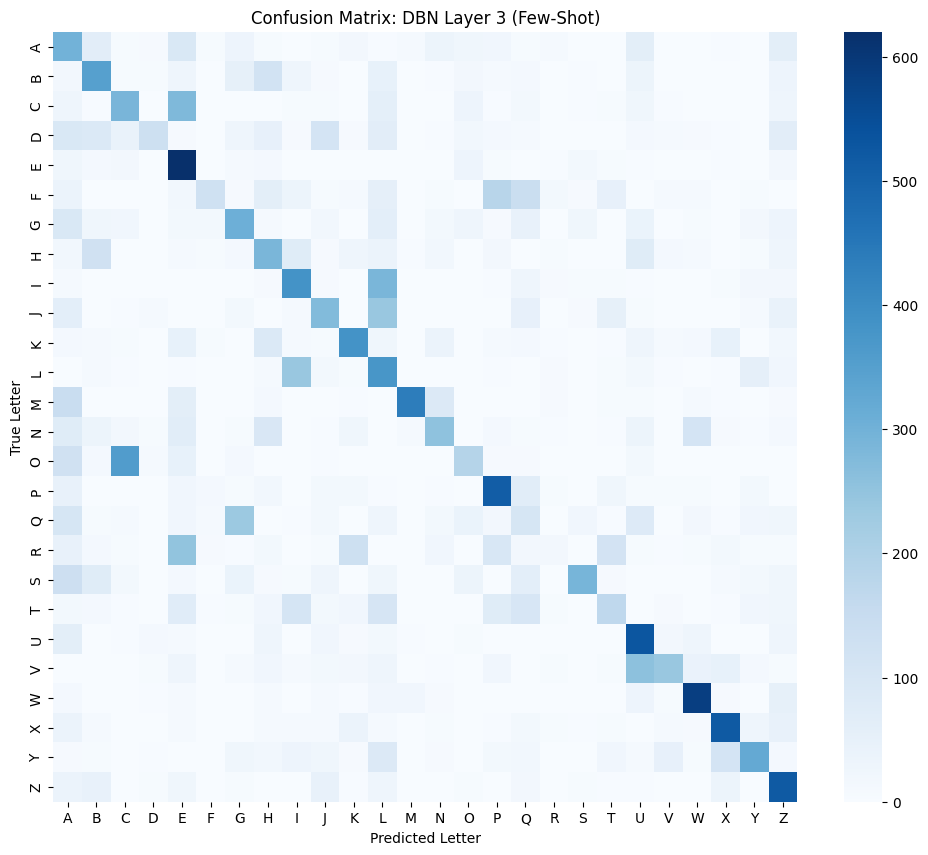

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        preds = model(test_features)
        pred_labels = torch.argmax(preds, dim=1).cpu().numpy()
        true_labels = test_labels.cpu().numpy()

    cm = confusion_matrix(true_labels, pred_labels)    
    plt.figure(figsize=(12, 10))
    alphabet = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
    
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=alphabet, yticklabels=alphabet)
    
    plt.title("Confusion Matrix: DBN Layer 3 (Few-Shot)")
    plt.xlabel("Predicted Letter")
    plt.ylabel("True Letter")
    plt.show()

print("matrix creation")
plot_confusion_matrix(linear3, hidden_repr_3_test, test_labels)